# 准备

## 首先的首先，用哪个数据库训练

In [1]:
GSE_Train = "GSE63990"

## 库 导入

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score
warnings.filterwarnings('ignore')

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC

## 数据 导入

In [4]:
gse = GEOparse.get_GEO(geo=GSE_Train, destdir="./datasets", silent=True)
gpls = gse.metadata['platform_id']
gpl = GEOparse.get_GEO(geo=gpls[0], destdir="./datasets", silent=True)

In [27]:
gse_csv = pd.read_csv('./datasets/' + GSE_Train + '.csv')
gse_csv.head() # 预览数据

,infection_status,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
0,non-infectious illness,107.026284,158.817338,2545.754898,186.244424,13.132469,643.402073,34.615676,17.490946,2929.019555,...,17.173226,422.464901,566.805882,481.918815,1421.477295,1302.020303,6250.362334,3836.600257,17740.725022,14961.589573
1,non-infectious illness,221.020421,124.644738,2143.929143,324.223899,15.427804,1001.622909,49.833883,22.848206,5667.531661,...,17.962223,652.117965,800.852865,822.133404,2305.851262,2008.050881,8731.397156,5399.129367,19067.890695,17285.989865
2,non-infectious illness,137.091142,115.353642,1741.194207,299.526479,13.588461,549.283988,47.869510,18.544460,3186.032084,...,17.282754,483.392556,566.237470,586.430031,1792.943487,1330.467773,7401.441597,4578.962962,18303.281696,15753.041045
3,non-infectious illness,126.175162,98.119250,1316.526914,326.999326,12.738011,339.984798,51.808930,19.624606,5535.493091,...,17.651712,1275.694498,1781.291882,1547.788940,3845.464156,3549.057271,11770.475723,7924.052042,23370.081259,19856.779557
4,bacterial,105.348086,260.359324,2930.300695,223.766173,12.436344,409.723526,35.071703,19.844859,581.984161,...,18.275624,404.702873,518.880900,477.676689,1299.615932,1186.047735,5968.686731,3780.851630,18440.196387,15535.017110


In [6]:
gse_csv.isnull().sum() 

infection_status        0
1007_s_at               0
1053_at                 0
117_at                  0
121_at                  0
                       ..
AFFX-r2-Ec-bioC-5_at    0
AFFX-r2-Ec-bioD-3_at    0
AFFX-r2-Ec-bioD-5_at    0
AFFX-r2-P1-cre-3_at     0
AFFX-r2-P1-cre-5_at     0
Length: 22278, dtype: int64

In [7]:
gse_csv['infection_status'].value_counts() # 看一下感染这个列的分布

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

## 函数 准备

In [219]:
def plot_score_distribution(ax, y_score, final_target):
    ax.scatter(range(len(y_score)), y_score, c=final_target, cmap='bwr', alpha=0.5)
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei'] # 中文乱码
    plt.rcParams['axes.unicode_minus']=False # 负号乱码
    labels = ['细菌感染', '病毒感染']
    ax.legend(labels, loc='upper right')
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')

def plot_roc_curve(ax, y_score, final_target):
    fpr, tpr, thresholds = roc_curve(final_target, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

def plot_pr_curve(ax, y_score, final_target):
    precision, recall, thresholds = precision_recall_curve(final_target, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

def plot_confusion_matrix(ax, y_score, final_target):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_target, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['病毒感染', '细菌感染'], rotation=45)
    plt.yticks(tick_marks, ['病毒感染', '细菌感染'])
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

def plot_all(score, target, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    plot_score_distribution(axs[0,0], score, target)
    plot_roc_curve(axs[0,1], score, target)
    plot_pr_curve(axs[1,0], score, target)
    plot_confusion_matrix(axs[1,1], score, target)
    if feature or weight:
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=12)
        except:
            pass
    return fig, axs

def testfeature(feature,weight,data,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimes(feature,weight,data,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimesandtarget(feature,weight,data,target,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)


In [278]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        # reselect the features
        reselect = SelectKBest(score_func=method, k=i)
        reselect.fit(X_train, y_train)
        model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
        y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
        train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
        test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
        train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
        test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
    X_train_new = select.transform(X_train)
    X_test_new = select.transform(X_test)
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的准确率为：', model.score(X_test_new, y_test))
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的AUC为：', roc_auc_score(y_test, y_pred))
    # # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的权重为：', model.coef_)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的截距为：', model.intercept_)
    # get column names
    gene_id = X_train.columns[select.get_support(indices=True)]
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


In [414]:
def test_method(select_method, model, n_feature, X_train, X_test, y_train, y_test):
    reselect = SelectKBest(score_func=select_method, k=n_feature)
    reselect.fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    print(X_train_new.shape)
    X_test_new = reselect.transform(X_test)
    print(X_test_new.shape)
    model.fit(X_train_new, y_train)
    y_score= predict(model, X_test_new)
    y_pred = model.predict(X_test_new)
    model_acc = np.mean(np.equal(y_pred, y_test))
    print('使用' + str(model) + '和' + select_method.__name__ + '选择特征后的准确率为：', model_acc)
    title = '使用' + select_method.__class__.__name__ + '选择' + str(n_feature) + '个特征的' + model.__class__.__name__ + '的直接运算的预测结果'
    gene_id = X_train.columns[reselect.get_support(indices=True)]
    feature = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    plot_all(
        score = y_score,
        target = y_test,
        title = title,
        feature = feature,
        weight = model.coef_)
    plt.show()
    coef = model.coef_

    times = np.logspace(1, 8, num=500, base=10)
    accs = []
    match = 0
    for time in times:
        y_score = predict(model, X_test_new, time)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_score], dtype=int)
        accs.append(np.mean(y_pred == y_test))
        if np.mean(y_pred == y_test) == model_acc:
            match += 1
            if match == 5:
                print('time =', time, 'acc =', np.mean(y_pred == y_test))
                print('coef =', np.round(model.coef_.ravel() * time))
                match = 0
        else:
            match = 0
    plt.plot(times, accs)
    plt.xlabel('times')
    plt.ylabel('accuracy')
    plt.title('Relationship between times and accuracy')
    plt.xscale('log')
    plt.show()

    coef = model.coef_

    return coef, reselect

In [394]:
def predict(model, X, time=None):
    # if not coef: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    if time is not None:
        coef = model.coef_.ravel() * time
        coef = np.round(coef)
    else:
        time = 1
        coef = model.coef_.ravel()
    if model.__class__.__name__ == 'LinearRegression':
        y_pred = np.dot(X, coef)/time + model.intercept_ 
    elif model.__class__.__name__ == 'RidgeClassifier':
        y_pred = np.dot(X, coef)/time + model.intercept_ + 0.5# 以0为分界（？
    elif model.__class__.__name__ == 'LogisticRegression':
        z = np.dot(X, coef)/time + model.intercept_
        y_pred = 1 / (1 + np.exp(-z))
        # y_pred = np.dot(X, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'LinearSVC':
        y_pred = np.dot(X, coef)/time + model.intercept_
    elif model.__class__.__name__ == 'NuSVC':
        y_pred = np.dot(X, coef)/time + model.intercept_ + 0.5 # 以0为分界（？
    return y_pred

In [258]:
def test_method(select_method, model, n_feature, X_train, X_test, y_train, y_test):
    reselect = SelectKBest(score_func=select_method, k=n_feature)
    reselect.fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    print(X_train_new.shape)
    X_test_new = reselect.transform(X_test)
    model.fit(X_train_new, y_train)
    print(model.coef_.shape)
    print(model.intercept_)
    
    # after fit, just use np.dot to calculate.
    if model.__class__.__name__ == 'LinearRegression':
        y_pred = np.dot(X_test_new, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'RidgeClassifier':
        y_pred = np.dot(X_test_new, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'LogisticRegression':
        z = np.dot(X_test_new, model.coef_.ravel()) + model.intercept_
        y_pred = 1 / (1 + np.exp(-z))
    elif model.__class__.__name__ == 'LinearSVC':
        y_pred = np.dot(X_test_new, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'NuSVC':
        y_pred = np.dot(X_test_new, model.coef_.ravel()) + model.intercept_

    title = '使用' + select_method.__class__.__name__ + '选择' + str(n_feature) + '个特征的' + model.__class__.__name__ + '的直接运算的预测结果'
    gene_id = X_train.columns[reselect.get_support(indices=True)]
    feature = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    plot_all(
        score = y_pred,
        target = y_test,
        title = title,
        feature = X_test_new,
        weight = model.coef_)

# 训练

## 分开病毒与未感染

In [9]:
# 病毒与未感染的鉴别
viral_data = gse_csv[gse_csv['infection_status'] != 'bacterial']
viral_data['infection_status'] = viral_data['infection_status'].map({'viral': 1, 'non-infectious illness': 0})
X_train, X_test, y_train, y_test = train_test_split(viral_data.drop(['infection_status'], axis=1), viral_data['infection_status'], test_size=0.2, random_state=0)
viral_data['infection_status'].value_counts()

1    117
0     90
Name: infection_status, dtype: int64

### 仅在 感染了后表达量的75%高于未感染的表达量的25%的基因中进行训练

In [10]:
viral_data = gse_csv[gse_csv['infection_status'] != 'bacterial']
viral_data['infection_status'].value_counts()
viral_data['infection_status'] = viral_data['infection_status'].map({'viral': 1, 'non-infectious illness': 0})
viral_data_describe = viral_data.groupby('infection_status').describe()
viral_data_higher_columns = []
viral_data_higher_columns.append('infection_status')
for i in range(viral_data_describe.shape[1]//8):
    # if the feature is not significant, that means, the mean of the viral ones is smaller than two times of the non-viral ones, drop it
    if (viral_data_describe.iloc[1,8*i+4]>
        viral_data_describe.iloc[0,8*i+6]):
        viral_data_higher_columns.append(viral_data_describe.columns[8*i+1][0])
viral_data_higher = viral_data[viral_data_higher_columns]
X_train, X_test, y_train, y_test = train_test_split(viral_data_higher.drop(['infection_status'], axis=1), viral_data_higher['infection_status'], test_size=0.2, random_state=0)
viral_data_higher

,infection_status,1294_at,200039_s_at,200041_s_at,200079_s_at,200600_at,200609_s_at,200618_at,200628_s_at,200629_at,...,55081_at,55662_at,57539_at,58994_at,60815_at,64408_s_at,64418_at,65630_at,AFFX-HSAC07/X00351_3_at,AFFX-HUMISGF3A/M97935_MB_at
0,0,643.402073,1340.549577,2920.802108,1419.365924,4557.693902,4211.947387,5304.629225,460.473715,1860.334880,...,240.855718,115.113468,356.914854,114.262220,40.352618,141.662588,523.030339,374.506849,21429.690894,190.122350
1,0,1001.622909,1727.275541,3878.535228,1788.372821,5914.227686,3911.342833,5342.411764,558.175089,2735.839120,...,296.189562,135.658500,496.593307,180.740581,46.388023,92.985173,474.472973,316.683748,19431.802210,89.211071
2,0,549.283988,965.861153,2902.943404,641.568088,6279.198785,4901.682965,5895.095052,399.272341,1619.061879,...,325.405783,74.756361,334.575812,126.928085,45.617479,64.890126,560.378859,290.250529,21529.355181,162.819594
3,0,339.984798,429.112173,1598.055546,873.192833,3866.060797,2867.456768,3791.391837,337.044829,1261.151562,...,156.420044,38.312478,200.171773,53.097219,68.636824,35.876727,248.602802,199.961604,19070.579193,135.533155
5,0,483.260626,1254.537213,3068.325644,926.174495,4646.376351,4252.613571,5122.562762,559.246683,1925.297333,...,219.780298,96.185508,283.554302,81.860539,72.684194,102.826453,505.536694,269.521803,21949.228645,295.993599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,1,777.372259,1083.696568,2055.250235,1225.333559,4087.528550,2186.895228,3926.748105,1787.933234,6262.359667,...,456.601912,53.792385,209.661875,94.393682,35.474495,60.265760,386.083388,131.407759,18560.572302,572.047929
273,0,365.191010,793.564708,2060.528352,890.080761,4067.542196,1860.013447,3327.607824,501.686756,1568.497612,...,166.070205,45.942884,206.404085,95.659533,36.005051,49.054269,326.751666,110.776658,17771.303527,168.677724
275,1,1278.450771,1224.402424,1675.206305,1332.265013,3598.271715,2145.707717,3663.414032,2397.555219,7614.845028,...,453.841597,72.422027,175.066455,71.203667,33.382782,63.851170,439.249347,133.913837,16452.297820,1114.683489
276,1,727.149062,1241.717262,3535.047127,1154.138580,5159.046030,2633.669819,4545.741801,425.725281,1626.407254,...,372.024840,121.165007,315.168220,98.035507,49.436194,75.272339,674.076969,161.641860,19614.955512,397.825792


### 再选一些画图看看

选

In [11]:
# select the best 30 features
k = 49
SelectKBest_chi2 = SelectKBest(chi2, k=k).fit(X_train, y_train)
SelectKBest_f_classif = SelectKBest(f_classif, k=k).fit(X_train, y_train)

select = [SelectKBest_chi2, SelectKBest_f_classif]
select_name = ['SelectKBest_chi2', 'SelectKBest_f_classif']

violinplot

In [12]:
# fig, ax = plt.subplots(len(select), k, figsize=(6*k, 40))
# for i in range(len(select)):
#     for j in range(k):
#         sns.violinplot(
#             x='infection_status', 
#             y=X_train.columns[select[i].get_support(indices=True)[j]], 
#             hue='infection_status',
#             inner='stick',
#             data=gse_csv, ax=ax[i][j])
#         ax[i][j].set_title(gpl.table[gpl.table['ID'] == X_train.columns[select[i].get_support(indices=True)[j]]]['Gene Symbol'].values[0])
#         # also add importance of the gene
#         ax[i][j].set_xlabel('importance: ' + str(select[i].scores_[select[i].get_support(indices=True)[j]]))
#         #对数坐标
#         ax[i][j].set_yscale('log')
#         # y is 0 to 10000
#         ax[i][j].set_ylim(10, 40000)
# plt.show()

In [13]:
fig, ax = plt.subplots(len(select), k, figsize=(6*k, 40))
for i in range(len(select)):
    for j in range(k):
        sns.boxplot(
            x='infection_status', 
            y=X_train.columns[select[i].get_support(indices=True)[j]], 
            data=gse_csv, ax=ax[i][j])
        ax[i][j].set_title(gpl.table[gpl.table['ID'] == X_train.columns[select[i].get_support(indices=True)[j]]]['Gene Symbol'].values[0])
        # also add importance of the gene
        ax[i][j].set_xlabel('importance: ' + str(select[i].scores_[select[i].get_support(indices=True)[j]]))
        #对数坐标
        ax[i][j].set_yscale('log')
        # y is 0 to 10000
        ax[i][j].set_ylim(10, 40000)
plt.show()

看看在范围内 使用不同的采样的效果

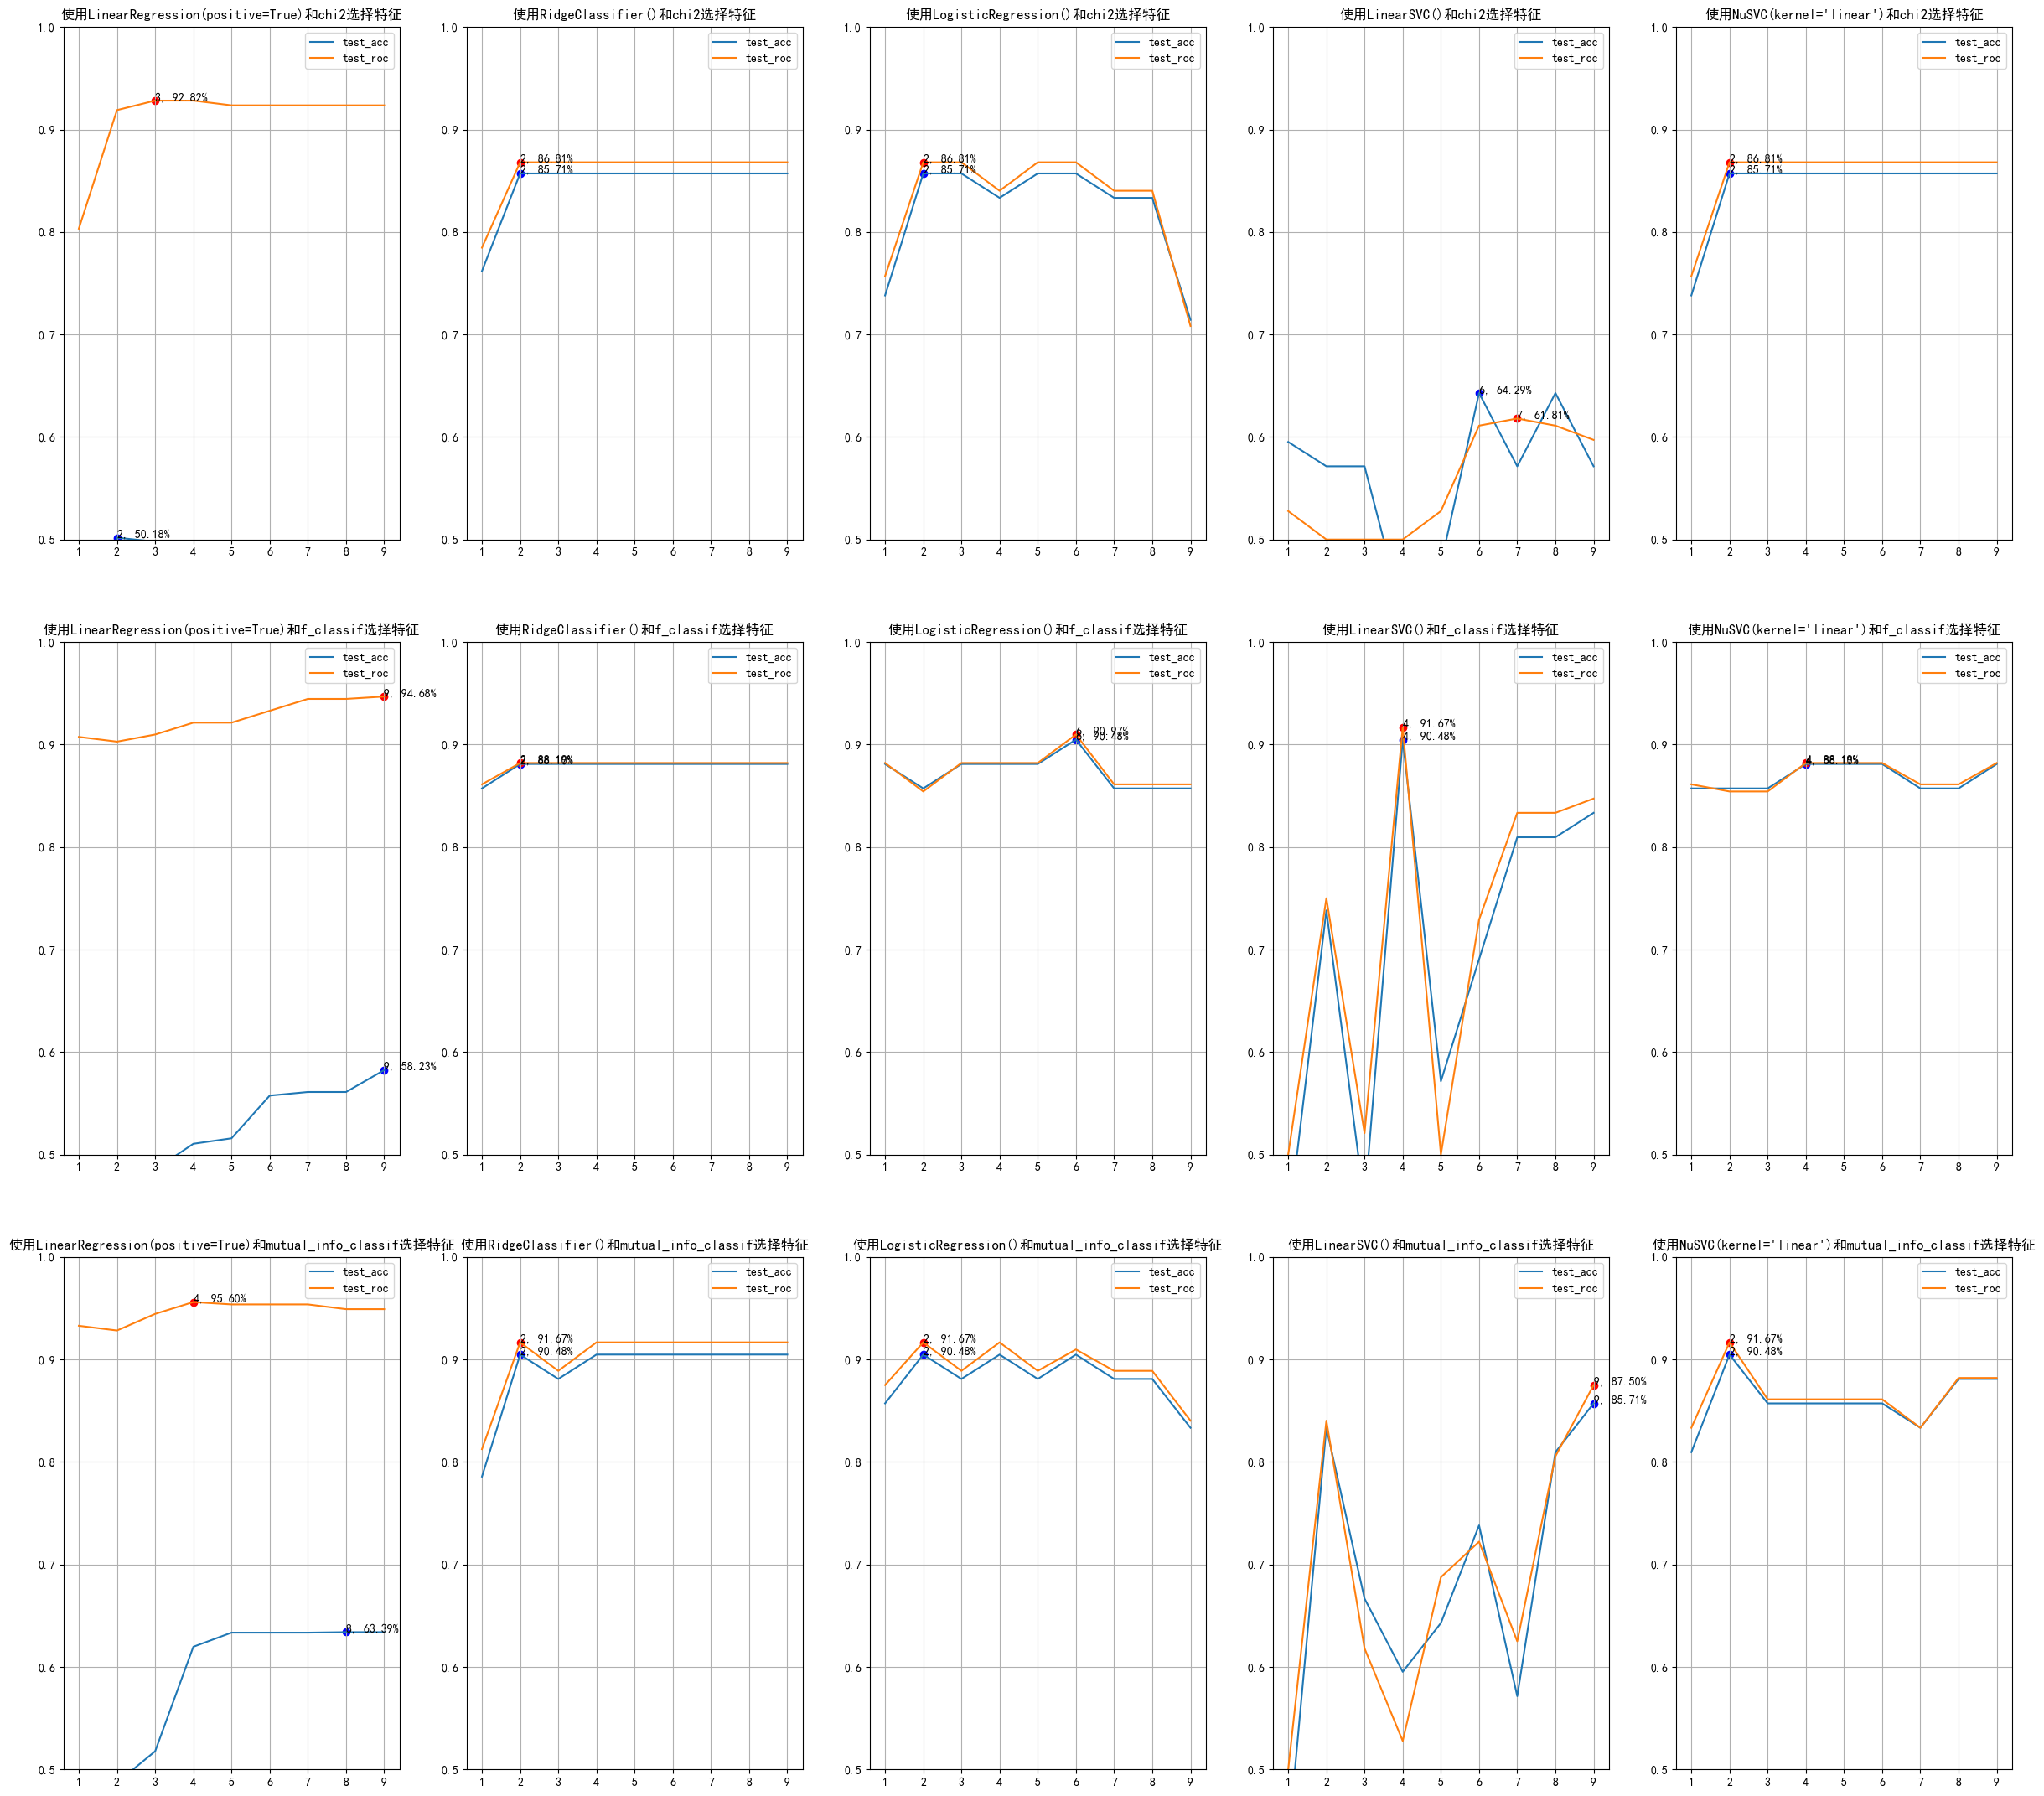

In [281]:
X_train, X_test, y_train, y_test = train_test_split(viral_data_higher.drop(['infection_status'], axis=1), viral_data_higher['infection_status'], test_size=0.2, random_state=0)

methods = [chi2, f_classif, mutual_info_classif]
models = [
    # https://scikit-learn.org/stable/modules/linear_model.html
    LinearRegression(
        positive=True
    ),                              # 普通最小二乘法 的 非负
    RidgeClassifier(
        # alpha=1
    ),                              # 是最小二乘法的正则化版本，明显快于例如 LogisticRegression，该分类器有时称为具有线性内核的最小二乘支持向量机
    LogisticRegression(
        # penalty='l2',
        # C=1
    ),                              # 逻辑回归
    # SVC(
    #     kernel='linear',
    #     class_weight='balanced'
    # ),                            # 超级超级超级慢
    LinearSVC(
        
    ),
    NuSVC(
        kernel='linear'
    )
]
# methods = [chi2]
# models = [LinearRegression()]
fig, axs = plt.subplots(len(methods), len(models), figsize=(6*len(models), 9*len(methods)))
test_accs = []
best_n = []
rocs = []
gene_symbols = []
coefs = []
for method in methods:
    for model in models:
        # find_best_n(axs[methods.index(method), models.index(model)], X_train, y_train, X_test, y_test, method, model, max_features=6)
        test_acc, n, gene_symbol, coef = find_best_n(
            axs[methods.index(method), models.index(model)], 
            X_train, y_train, X_test, y_test, 
            method, 
            model, 
            max_features=10)
        test_accs.append(test_acc)
        best_n.append(n)
        gene_symbols.append(gene_symbol)
        coefs.append(coef)
plt.show()

In [289]:
best_acc = max(test_accs)
best_i = 0
i = 0
print('最好的准确率为：', acc)
for acc in test_accs:
    if acc == best_acc:
        print('='*60)
        print('对应的特征数为：', best_n[i],'对应的方法为：', methods[i // len(models)].__name__,'对应的特征为：', gene_symbols[i])
        print('对应的模型为：', models[i % len(models)],'对应的特征权重为：', coefs[i])
    i += 1

最好的准确率为： 0.9047619047619048
对应的特征数为： 6 对应的方法为： f_classif 对应的特征为： ['MIR7703 /// PSME2', 'BTN3A2 /// BTN3A3', 'BTN3A3', 'LCP2', 'BTN3A2', 'BTN3A3']
对应的模型为： LogisticRegression() 对应的特征权重为： [[ 9.86338968e-04  5.16560362e-04 -5.00454643e-03  9.59925385e-05
   4.43529043e-04  1.07078492e-02]]
对应的特征数为： 4 对应的方法为： f_classif 对应的特征为： ['MIR7703 /// PSME2', 'BTN3A2 /// BTN3A3', 'BTN3A3', 'BTN3A2']
对应的模型为： LinearSVC() 对应的特征权重为： [[ 0.00070761 -0.00092458  0.00235946  0.00050427]]
对应的特征数为： 2 对应的方法为： mutual_info_classif 对应的特征为： ['DRAP1', 'BTN3A3']
对应的模型为： RidgeClassifier() 对应的特征权重为： [[0.00062713 0.00125388]]
对应的特征数为： 2 对应的方法为： mutual_info_classif 对应的特征为： ['DRAP1', 'BTN3A3']
对应的模型为： LogisticRegression() 对应的特征权重为： [[0.00777919 0.00650439]]
对应的特征数为： 2 对应的方法为： mutual_info_classif 对应的特征为： ['DRAP1', 'BTN3A3']
对应的模型为： NuSVC(kernel='linear') 对应的特征权重为： [[0.00200213 0.0023402 ]]


(130, 2)
(33, 2)
使用RidgeClassifier()和mutual_info_classif选择特征后的准确率为： 0.8787878787878788


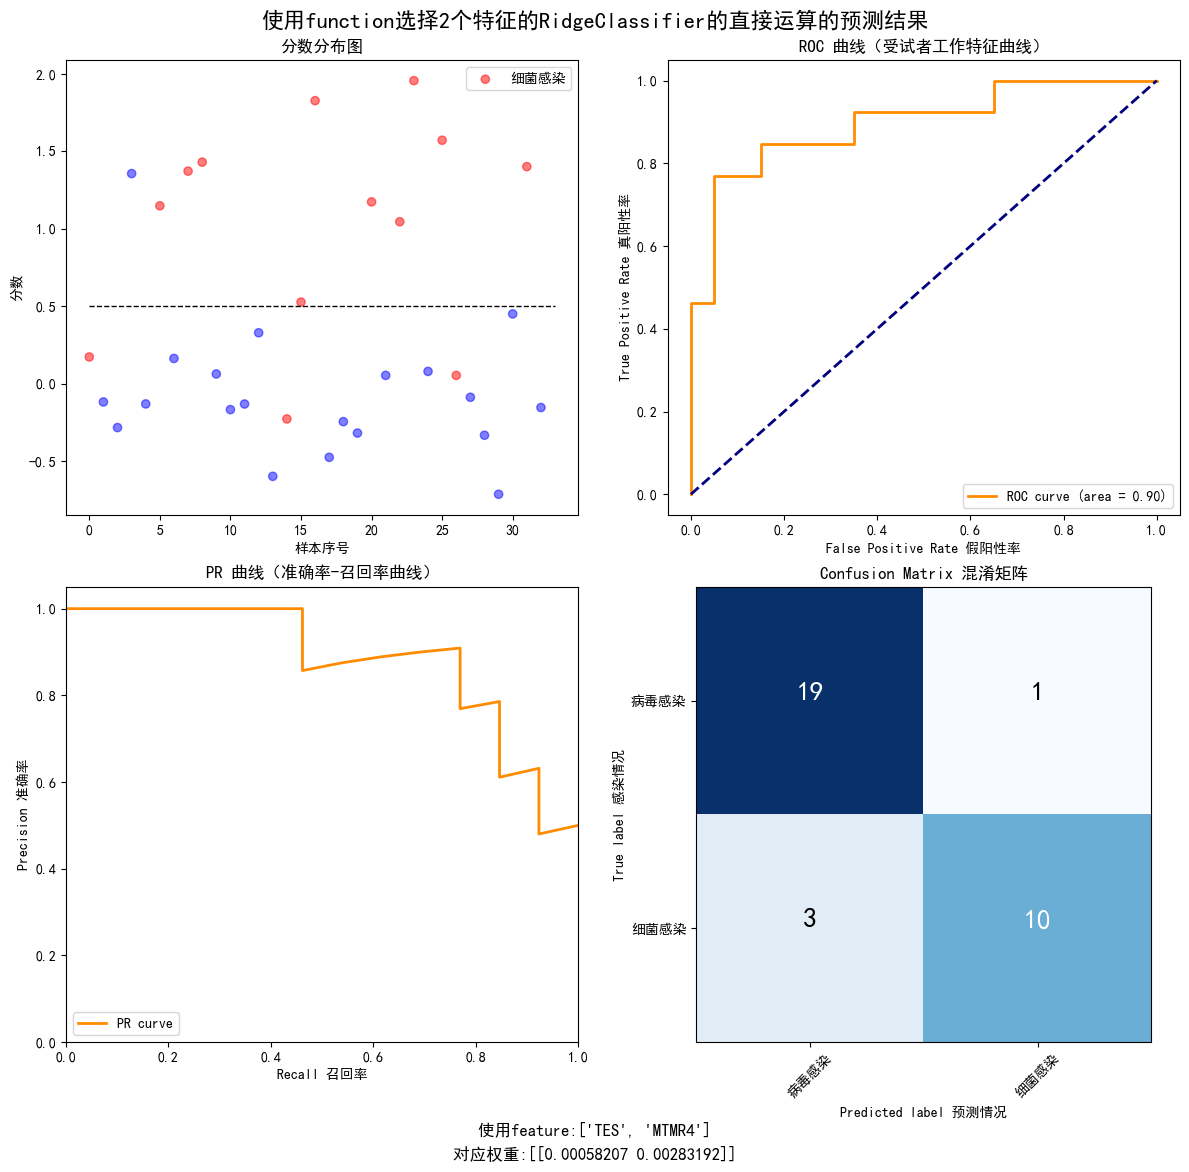

time = 7273.165113001462 acc = 0.8787878787878788
coef = [ 4. 21.]
time = 9118.42519614657 acc = 0.8787878787878788
coef = [ 5. 26.]
time = 13008.537010905733 acc = 0.8787878787878788
coef = [ 8. 37.]
time = 15288.635880587295 acc = 0.8787878787878788
coef = [ 9. 43.]
time = 19167.48492056813 acc = 0.8787878787878788
coef = [11. 54.]
time = 22527.106426459828 acc = 0.8787878787878788
coef = [13. 64.]
time = 26475.59270567064 acc = 0.8787878787878788
coef = [15. 75.]
time = 31116.15827824363 acc = 0.8787878787878788
coef = [18. 88.]
time = 36570.10880777493 acc = 0.8787878787878788
coef = [ 21. 104.]
time = 42980.01206490798 acc = 0.8787878787878788
coef = [ 25. 122.]
time = 50513.424688167666 acc = 0.8787878787878788
coef = [ 29. 143.]
time = 59367.27216069126 acc = 0.8787878787878788
coef = [ 35. 168.]
time = 69772.99649665538 acc = 0.8787878787878788
coef = [ 41. 198.]
time = 82002.6061993413 acc = 0.8787878787878788
coef = [ 48. 232.]
time = 96375.7866384109 acc = 0.8787878787878788

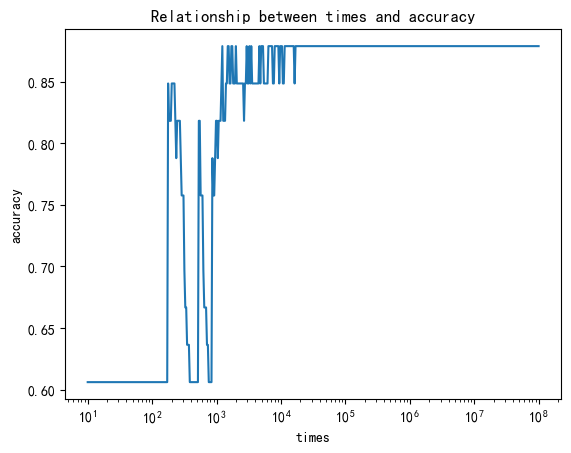

(130, 2)
(33, 2)
使用LogisticRegression()和mutual_info_classif选择特征后的准确率为： 0.8484848484848485


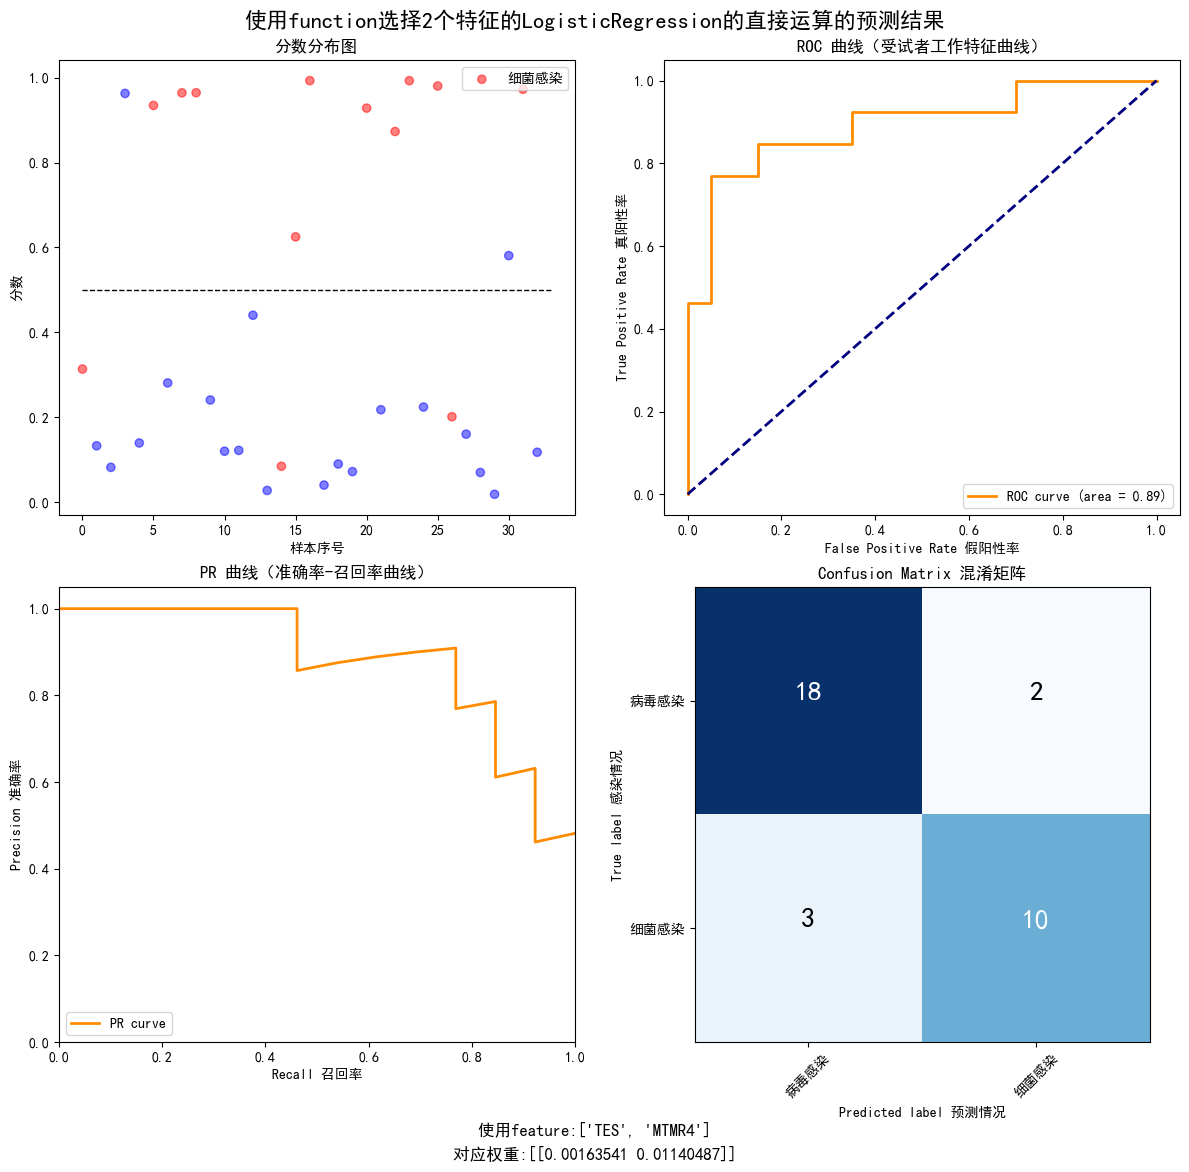

time = 604.7322449462649 acc = 0.8484848484848485
coef = [1. 7.]
time = 710.7279696773419 acc = 0.8484848484848485
coef = [1. 8.]
time = 1230.7798025066659 acc = 0.8484848484848485
coef = [ 2. 14.]
time = 1813.4978041964953 acc = 0.8484848484848485
coef = [ 3. 21.]
time = 2131.3624718414376 acc = 0.8484848484848485
coef = [ 3. 24.]
time = 2504.9415421745025 acc = 0.8484848484848485
coef = [ 4. 29.]
time = 2944.000475100034 acc = 0.8484848484848485
coef = [ 5. 34.]
time = 3460.016392185112 acc = 0.8484848484848485
coef = [ 6. 39.]
time = 4066.478091781858 acc = 0.8484848484848485
coef = [ 7. 46.]
time = 4779.2386499356 acc = 0.8484848484848485
coef = [ 8. 55.]
time = 5616.92982416381 acc = 0.8484848484848485
coef = [ 9. 64.]
time = 6601.44909273489 acc = 0.8484848484848485
coef = [11. 75.]
time = 7758.532060787836 acc = 0.8484848484848485
coef = [13. 88.]
time = 9118.42519614657 acc = 0.8484848484848485
coef = [ 15. 104.]
time = 10716.676480328644 acc = 0.8484848484848485
coef = [ 18. 1

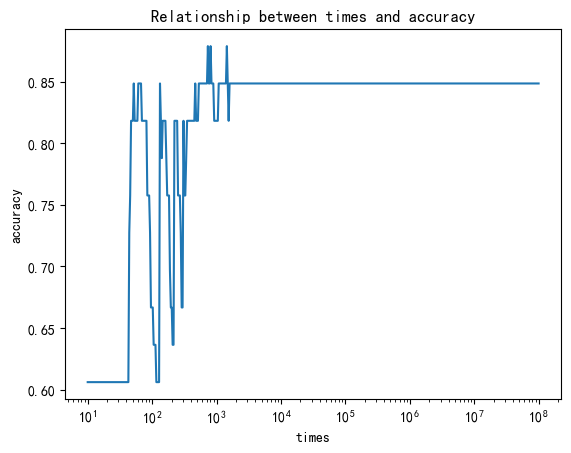

(130, 2)
(33, 2)
使用NuSVC(kernel='linear')和mutual_info_classif选择特征后的准确率为： 0.8484848484848485


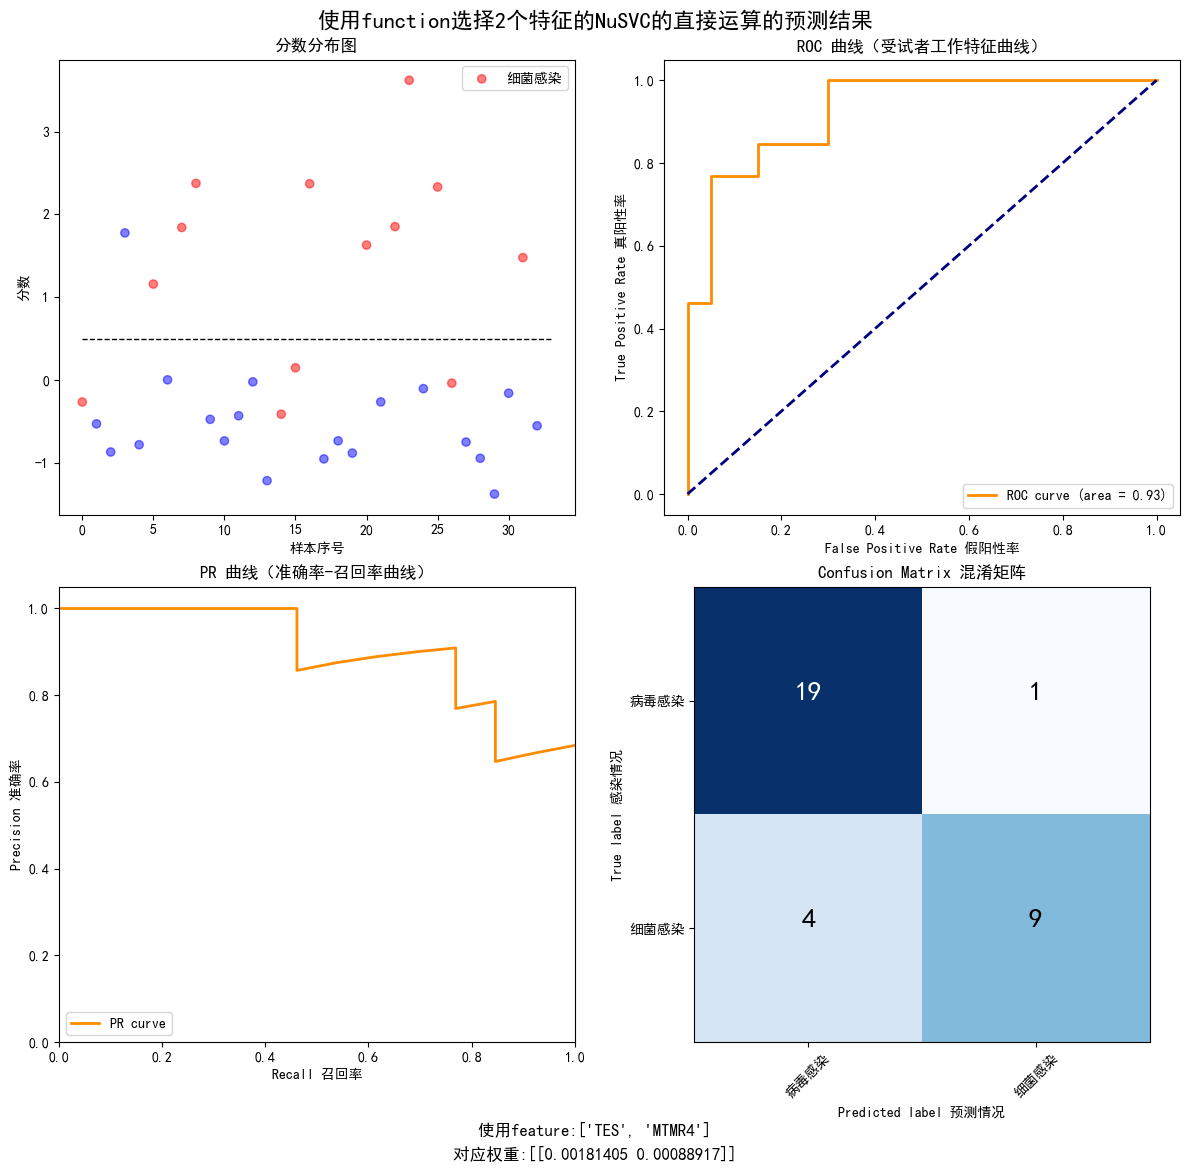

time = 452.1792417370702 acc = 0.8484848484848485
coef = [1. 0.]
time = 531.4359158053242 acc = 0.8484848484848485
coef = [1. 0.]
time = 624.5844712439618 acc = 0.8484848484848485
coef = [1. 1.]
time = 734.0598369757212 acc = 0.8484848484848485
coef = [1. 1.]
time = 1081.6036303107105 acc = 0.8484848484848485
coef = [2. 1.]
time = 1271.1839968690288 acc = 0.8484848484848485
coef = [2. 1.]
time = 1493.9934636052578 acc = 0.8484848484848485
coef = [3. 1.]
time = 1755.8563314144687 acc = 0.8484848484848485
coef = [3. 2.]
time = 2063.6177678638587 acc = 0.8484848484848485
coef = [4. 2.]
time = 2425.322741760353 acc = 0.8484848484848485
coef = [4. 2.]
time = 2850.426320853435 acc = 0.8484848484848485
coef = [5. 3.]
time = 3350.0408299131327 acc = 0.8484848484848485
coef = [6. 3.]
time = 3937.226329963479 acc = 0.8484848484848485
coef = [7. 4.]
time = 4627.332011878693 acc = 0.8484848484848485
coef = [8. 4.]
time = 5438.397428464801 acc = 0.8484848484848485
coef = [10.  5.]
time = 6391.62405

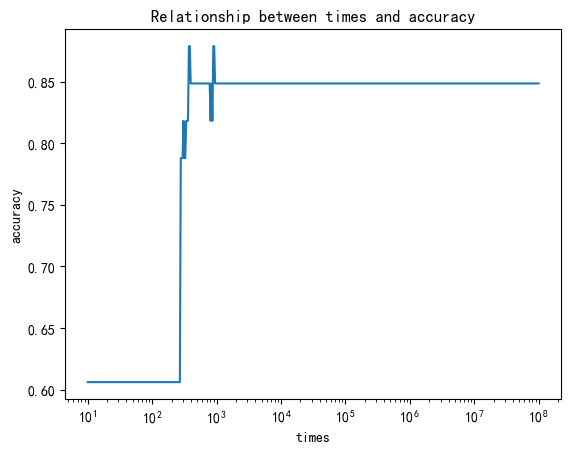

In [417]:
models_test = [
    RidgeClassifier(),
    LogisticRegression(),
    NuSVC(kernel='linear')
]
for model in models_test:
    coef, reselect = test_method(
        mutual_info_classif , 
        model,
        2, 
        X_train, X_test, y_train, y_test)

## 细菌

In [22]:
# 病毒与未感染的鉴别
bacterial_data = gse_csv[gse_csv['infection_status'] != 'viral']
bacterial_data['infection_status'] = bacterial_data['infection_status'].map({'bacterial': 1, 'non-infectious illness': 0})
X_train, X_test, y_train, y_test = train_test_split(bacterial_data.drop(['infection_status'], axis=1), bacterial_data['infection_status'], test_size=0.2, random_state=0)
bacterial_data['infection_status'].value_counts()

0    90
1    73
Name: infection_status, dtype: int64

In [23]:
# todo make_higher_data
def make_higher_data(data):
    data = data[data['infection_status'] != -1]
    data['infection_status'].value_counts()
    data_describe = data.groupby('infection_status').describe()
    data_higher_columns = []
    data_higher_columns.append('infection_status')
    for i in range(data_describe.shape[1]//8):
        if (data_describe.iloc[1,8*i+4]>
            data_describe.iloc[0,8*i+6]):
            data_higher_columns.append(data_describe.columns[8*i+1][0])
    data_higher = data[data_higher_columns, 'infection_status']
    return data_higher


In [28]:
bacterial_data = gse_csv[gse_csv['infection_status'] != 'viral']
bacterial_data['infection_status'].value_counts()
bacterial_data['infection_status'] = bacterial_data['infection_status'].map({'bacterial': 1, 'non-infectious illness': 0})
bacterial_data_describe = bacterial_data.groupby('infection_status').describe()
bacterial_data_higher_columns = []
bacterial_data_higher_columns.append('infection_status')
for i in range(bacterial_data_describe.shape[1]//8):
    # if the feature is not significant, that means, the mean of the viral ones is smaller than two times of the non-viral ones, drop it
    if (bacterial_data_describe.iloc[1,8*i+4]>
        bacterial_data_describe.iloc[0,8*i+6]):
        bacterial_data_higher_columns.append(bacterial_data_describe.columns[8*i+1][0])
bacterial_data_higher = bacterial_data[bacterial_data_higher_columns]
X_train, X_test, y_train, y_test = train_test_split(bacterial_data_higher.drop(['infection_status'], axis=1), bacterial_data_higher['infection_status'], test_size=0.2, random_state=0)
bacterial_data_higher

,infection_status,200096_s_at,200600_at,200603_at,200609_s_at,200618_at,200639_s_at,200640_at,200663_at,200685_at,...,51146_at,52731_at,54051_at,55692_at,58696_at,58994_at,64408_s_at,65630_at,91684_g_at,AFFX-HSAC07/X00351_3_at
0,0,8745.946149,4557.693902,2700.155485,4211.947387,5304.629225,4696.984183,6131.544369,4949.901324,85.366024,...,128.686790,71.104715,73.476434,856.963810,474.150619,114.262220,141.662588,374.506849,200.020365,21429.690894
1,0,7345.101084,5914.227686,485.202244,3911.342833,5342.411764,3525.346038,4068.617414,6392.705022,24.463078,...,66.144907,82.154869,60.832537,538.050526,519.220869,180.740581,92.985173,316.683748,247.730955,19431.802210
2,0,11397.940451,6279.198785,3709.252077,4901.682965,5895.095052,7359.666514,7112.296235,7637.493861,43.087824,...,144.560038,76.700922,127.124461,1942.969205,462.053147,126.928085,64.890126,290.250529,236.344255,21529.355181
3,0,7430.970260,3866.060797,2842.228640,2867.456768,3791.391837,3608.484369,4100.733719,3802.788217,65.942181,...,80.106937,73.078754,71.730044,715.019678,307.820708,53.097219,35.876727,199.961604,195.494086,19070.579193
4,1,8523.085030,3520.345471,4078.964766,4635.864392,4258.433632,5738.776605,6992.318181,10542.374742,177.034866,...,157.194267,72.947263,70.836251,925.610374,428.618047,121.257679,94.161830,255.525729,225.140987,22527.764233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,0,4255.598171,4067.542196,523.171568,1860.013447,3327.607824,2420.737559,2133.202880,3548.316929,13.266013,...,61.313435,70.323795,53.500761,387.218976,301.462968,95.659533,49.054269,110.776658,147.669519,17771.303527
274,1,4695.243588,4297.464879,1301.039860,2813.274311,4134.869547,3780.889683,2936.982010,6147.787866,13.724278,...,82.411962,78.241476,65.203646,780.220201,798.413950,105.845334,44.166145,117.579164,318.315143,18725.252146
277,1,4377.897938,6275.023222,2714.919034,2794.402656,4541.008542,3904.795360,3300.146690,4705.945004,23.746626,...,85.306749,90.260400,55.529563,1015.934161,760.074903,108.144636,53.016349,141.057548,300.245850,21034.067703
278,1,7100.195323,5929.940988,4885.277426,3352.012038,4164.858212,5344.822758,5558.585796,8969.208490,33.422151,...,106.595374,83.245485,59.102298,1673.469738,1935.092937,57.068637,65.509480,132.949208,760.567953,22411.476421


选

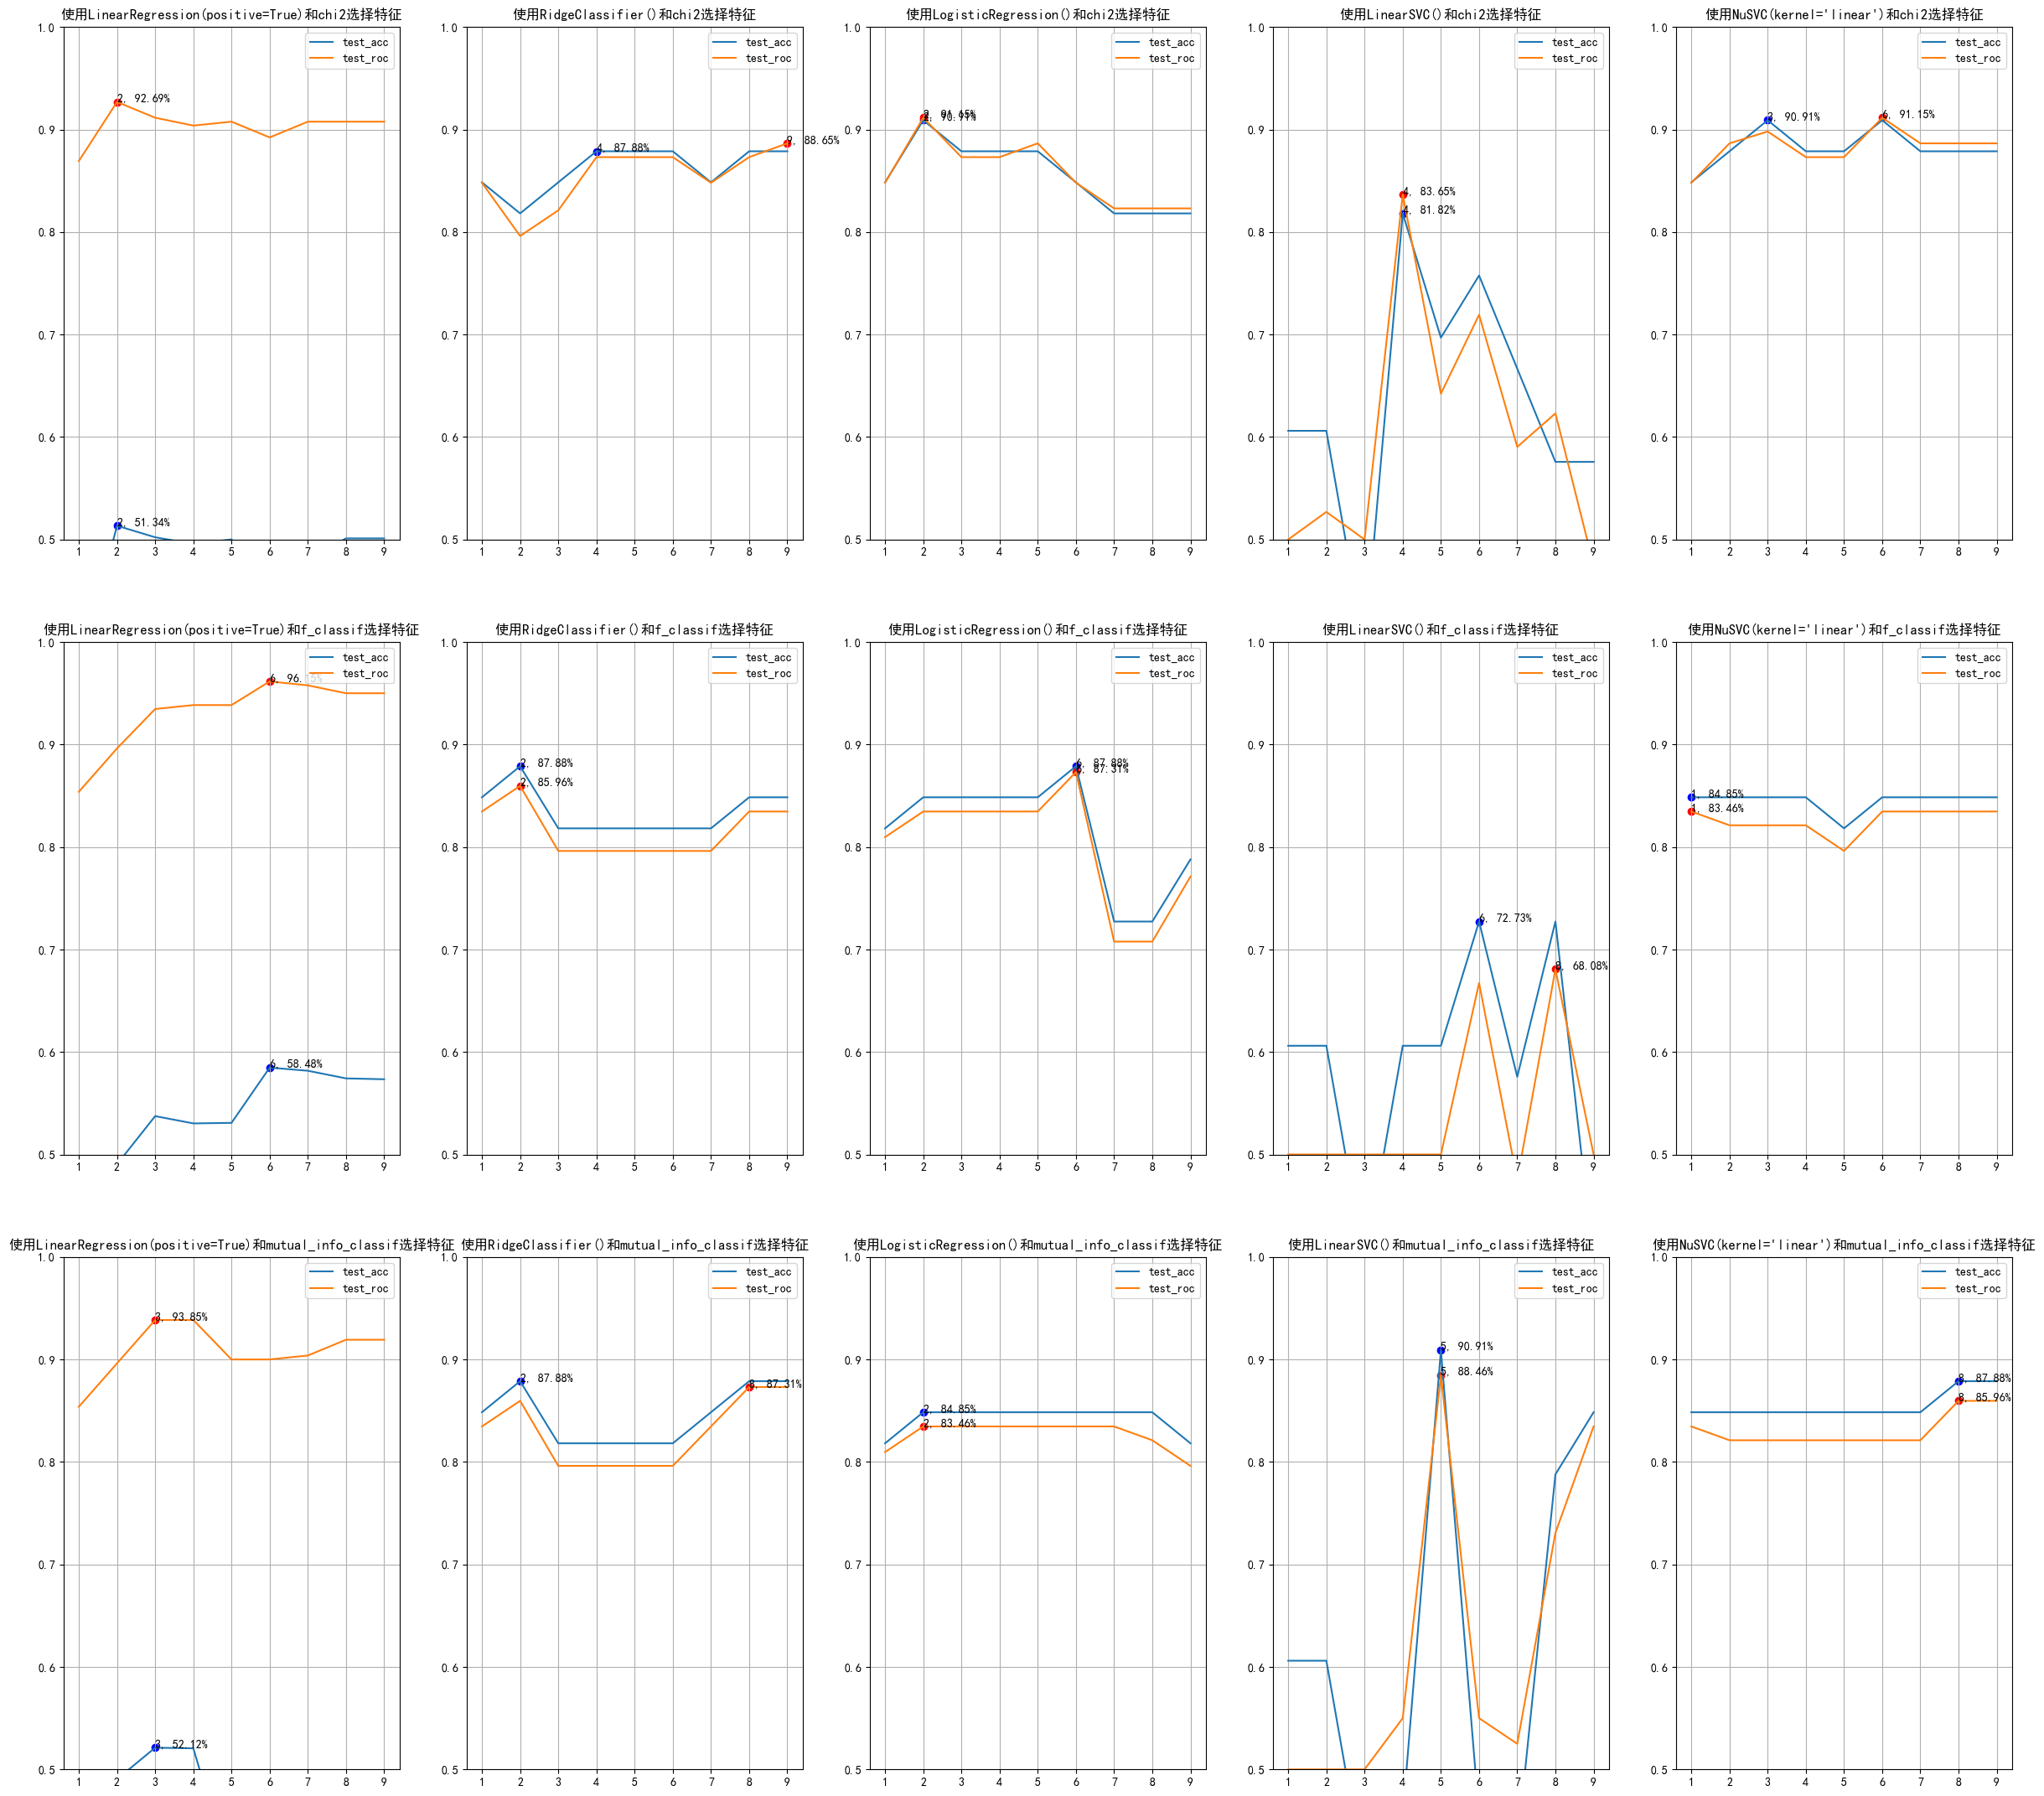

In [406]:
X_train, X_test, y_train, y_test = train_test_split(bacterial_data_higher.drop(['infection_status'], axis=1), bacterial_data_higher['infection_status'], test_size=0.2, random_state=0)

methods = [chi2, f_classif, mutual_info_classif]
models = [
    # https://scikit-learn.org/stable/modules/linear_model.html
    LinearRegression(
        positive=True
    ),                              # 普通最小二乘法 的 非负
    RidgeClassifier(
        # alpha=1
    ),                              # 是最小二乘法的正则化版本，明显快于例如 LogisticRegression，该分类器有时称为具有线性内核的最小二乘支持向量机
    LogisticRegression(
        # penalty='l2',
        # C=1
    ),                              # 逻辑回归
    # SVC(
    #     kernel='linear',
    #     class_weight='balanced'
    # ),                            # 超级超级超级慢
    LinearSVC(
        
    ),
    NuSVC(
        kernel='linear'
    )
]
# methods = [chi2]
# models = [LinearRegression()]
fig, axs = plt.subplots(len(methods), len(models), figsize=(6*len(models), 9*len(methods)))
test_accs = []
best_n = []
rocs = []
gene_symbols = []
coefs = []
for method in methods:
    for model in models:
        # find_best_n(axs[methods.index(method), models.index(model)], X_train, y_train, X_test, y_test, method, model, max_features=6)
        test_acc, n, gene_symbol, coef = find_best_n(
            axs[methods.index(method), models.index(model)], 
            X_train, y_train, X_test, y_test, 
            method, 
            model, 
            max_features=10)
        test_accs.append(test_acc)
        best_n.append(n)
        gene_symbols.append(gene_symbol)
        coefs.append(coef)
plt.show()

In [407]:
best_acc = max(test_accs)
best_i = 0
i = 0
print('最好的准确率为：', acc)
for acc in test_accs:
    if acc == best_acc:
        print('='*60)
        print('对应的特征数为：', best_n[i],'对应的方法为：', methods[i // len(models)].__name__,'对应的特征为：', gene_symbols[i])
        print('对应的模型为：', models[i % len(models)],'对应的特征权重为：', coefs[i])
    i += 1

最好的准确率为： 0.9047619047619048
对应的特征数为： 2 对应的方法为： chi2 对应的特征为： ['PLAC8', 'CD177']
对应的模型为： LogisticRegression() 对应的特征权重为： [[3.40887657e-04 8.88073107e-05]]
对应的特征数为： 3 对应的方法为： chi2 对应的特征为： ['GYG1', 'PLAC8', 'CD177']
对应的模型为： NuSVC(kernel='linear') 对应的特征权重为： [[1.05200590e-04 1.05555499e-04 7.40860852e-05]]
对应的特征数为： 5 对应的方法为： mutual_info_classif 对应的特征为： ['ANP32A', 'TES', 'TK2', 'MTMR4', 'DTWD1']
对应的模型为： LinearSVC() 对应的特征权重为： [[ 0.00080697  0.00038729  0.00425529  0.00048698 -0.06189641]]


(130, 3)
(33, 3)
使用NuSVC(kernel='linear')和chi2选择特征后的准确率为： 0.9090909090909091


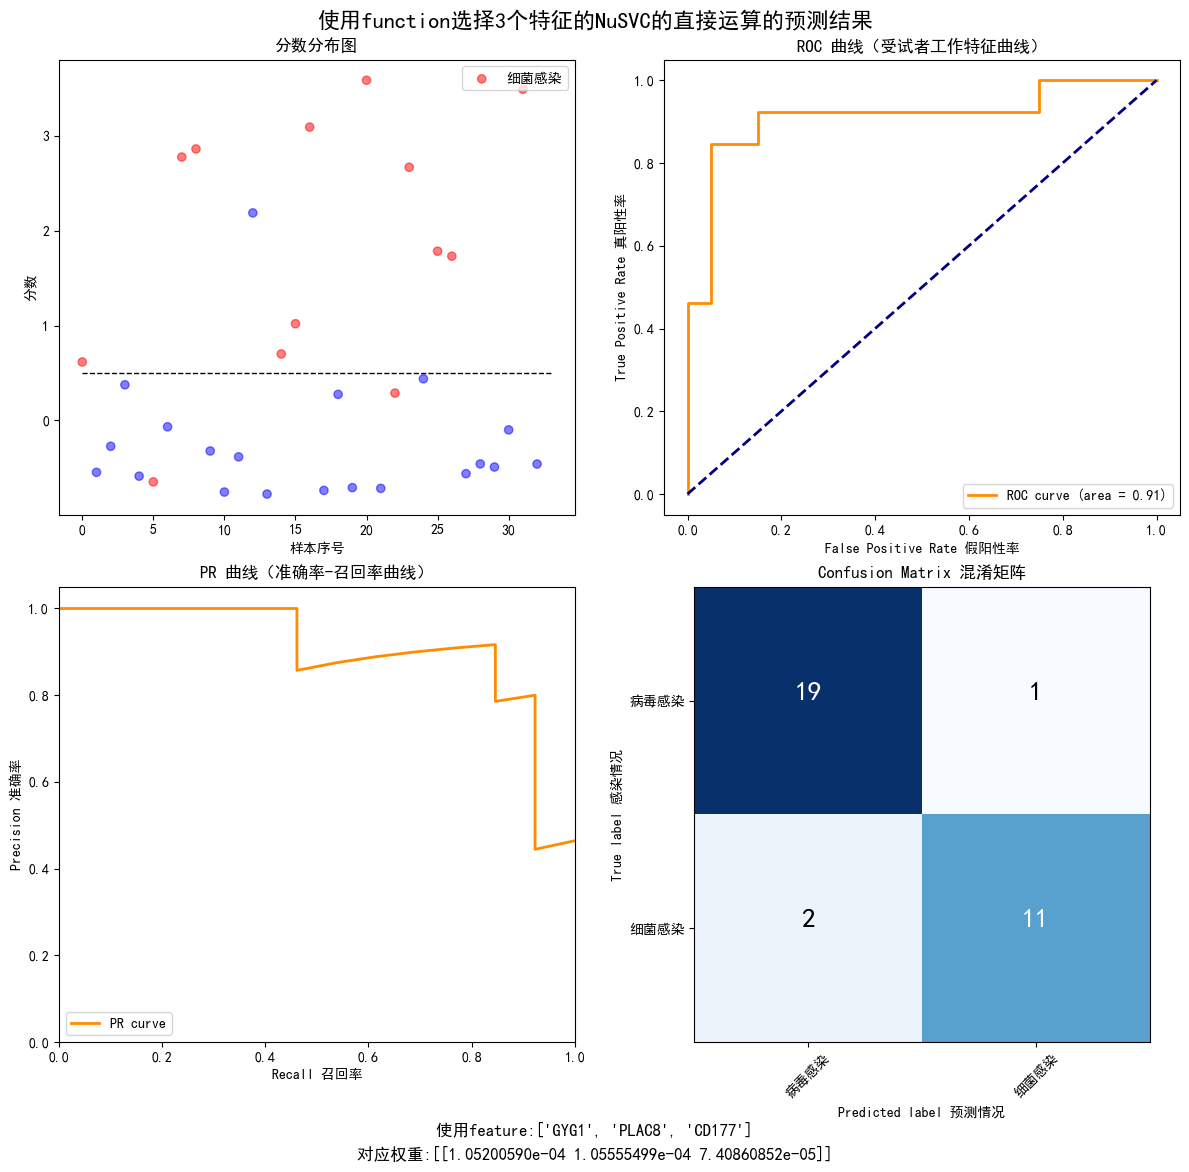

time = 55653.3077842764 acc = 0.9090909090909091
coef = [6. 6. 4.]
time = 87474.96301554416 acc = 0.9090909090909091
coef = [9. 9. 6.]
time = 106182.29410993846 acc = 0.9090909090909091
coef = [11. 11.  8.]
time = 124793.62054713114 acc = 0.9090909090909091
coef = [13. 13.  9.]
time = 146667.08663439687 acc = 0.9090909090909091
coef = [15. 15. 11.]
time = 172374.470806362 acc = 0.9090909090909091
coef = [18. 18. 13.]
time = 202587.7711735017 acc = 0.9090909090909091
coef = [21. 21. 15.]
time = 238096.77173803584 acc = 0.9090909090909091
coef = [25. 25. 18.]
time = 279829.68756551156 acc = 0.9090909090909091
coef = [29. 30. 21.]
time = 328877.428582551 acc = 0.9090909090909091
coef = [35. 35. 24.]
time = 386522.11626312614 acc = 0.9090909090909091
coef = [41. 41. 29.]
time = 454270.59863740427 acc = 0.9090909090909091
coef = [48. 48. 34.]
time = 533893.839714735 acc = 0.9090909090909091
coef = [56. 56. 40.]
time = 627473.2129711575 acc = 0.9090909090909091
coef = [66. 66. 46.]
time = 73

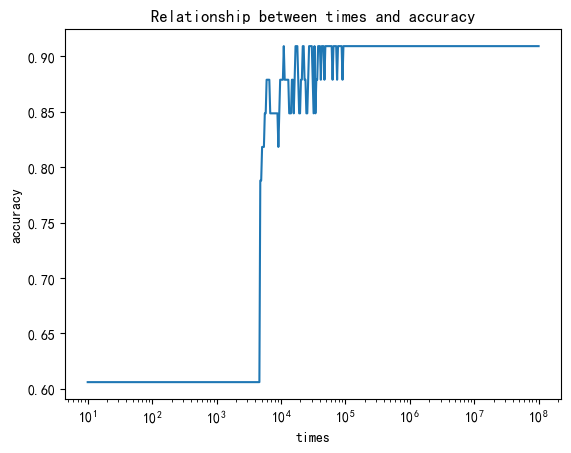

In [415]:
models_test = [
    NuSVC(kernel='linear')
]
for model in models_test:
    coef, reselect = test_method(
        chi2  , 
        model,
        3, 
        X_train, X_test, y_train, y_test)

# 测试

In [418]:
viral_feature =  ['TES', 'MTMR4']
viral_weight =  [4, 21] 
viral_times = 15
bacterial_feature = ['GYG1', 'PLAC8', 'CD177']
bacterial_weight = [15, 15, 11]
bacterial_times = 12

In [419]:
def cal_score(feature, weight, times, data):
    score = []
    indexs = []
    for i in range(len(feature)):
        id = gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0]
        index = data.columns.get_loc(id)
        indexs.append(index)
    for i in range(len(data)):
        score.append(
            np.dot(
                data.iloc[i, indexs].values,weight
                )/times
            )
    return score

Text(0, 0.5, 'bacterial_score')

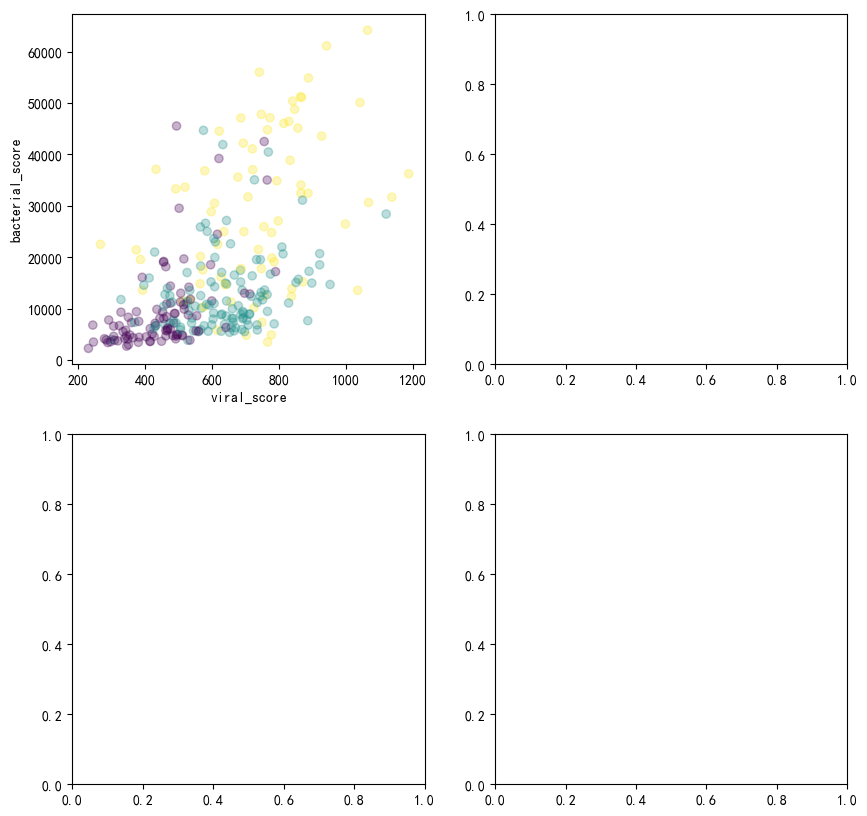

In [421]:
viral_score = cal_score(viral_feature, viral_weight,viral_times, gse_csv)
bacterial_score = cal_score(bacterial_feature, bacterial_weight,bacterial_times, gse_csv)
y = gse_csv['infection_status'].map({'viral': 1, 'non-infectious illness': 0, 'bacterial': 2})

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(
    viral_score,
    bacterial_score,
    c=y,
    alpha=0.3
)
ax[0,0].set_xlabel('viral_score')
ax[0,0].set_ylabel('bacterial_score')
# 比例尺保持一致
# ax[0,0].set_aspect('equal')